In [1]:
import pandas as pd
import numpy as np
import pickle
import numpy as np
import warnings
import sklearn

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import linear_model
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.2f}'.format

#### **Load model object**

In [2]:
import gcsfs

fs = gcsfs.GCSFileSystem(project='aes-datahub-0002')
fs.ls('aes-datahub-0002-curated/Outage_Restoration/Historical_Data/PickleFiles')
with fs.open('aes-datahub-0002-curated/Outage_Restoration/Historical_Data/PickleFiles/Random_Forest_GridSearch_09172020.pkl', 'rb') as f:
    rf_model = pickle.load(f)

#### **Load Features List**

In [3]:
features_df = pd.read_csv('gs://aes-datahub-0002-curated/Outage_Restoration/Historical_Data/PickleFiles/Random_Forest_GridSearch_09172020.csv', index_col = 0)
features_df.head()

,ModelObject,Features_List
0,Random_Forest_GridSearch_09172020,windDir100mAvg
1,Random_Forest_GridSearch_09172020,POWER_OUT_CLUE_FLG_True
2,Random_Forest_GridSearch_09172020,Hour_Cos
3,Random_Forest_GridSearch_09172020,FUSE_OCCURN_FLG_False
4,Random_Forest_GridSearch_09172020,NO_OF_IVR_CLUE_PER_DAY


In [4]:
feautres_list = list(features_df.Features_List)
feautres_list

['windDir100mAvg',
 'POWER_OUT_CLUE_FLG_True',
 'Hour_Cos',
 'FUSE_OCCURN_FLG_False',
 'NO_OF_IVR_CLUE_PER_DAY',
 'NO_OF_POWER_OUT_CLUE_PER_DAY',
 'Outages_in_last_1hr',
 'Priority_Customer_Qty',
 'ANIMAL_CAUSE_FLG_False',
 'UG_CAUSE_FLG_False',
 'tempRange',
 'NO_OF_WIRE_OCCURN_PER_DAY',
 'radSolarTot',
 'PUBLIC_SAFETY_OCCURN_FLG_True',
 'Outages_in_last_10hr',
 'NO_CAUSE_FLG_False',
 'cldCvrRange',
 'windSpd80mMax',
 'Hour_Sin',
 'CALL_QTY',
 'NO_OF_OPEN_DEVICE_CLUE_PER_DAY',
 'TREE_CAUSE_FLG_True',
 'Outages_in_last_2hr',
 'TREE_CAUSE_FLG_False',
 'Priority_Dist_Customer_Qty',
 'relHumAvg',
 'POLE_CLUE_FLG_False',
 'DOWNSTREAM_CUST_QTY',
 'Outages_in_last_9hr',
 'heatIndexMax',
 'DAY_FLAG_True',
 'WIRE_OCCURN_FLG_False',
 'ANIMAL_CAUSE_FLG_True',
 'ST_OCCURN_FLG_False',
 'CITY_NAM_NO_CITY',
 'PUBLIC_SAFETY_OCCURN_FLG_False',
 'ST_OCCURN_FLG_True',
 'POWER_OUT_CLUE_FLG_False']

#### **Load Analytical dataset**

In [5]:
load_ads = pd.read_csv('gs://aes-datahub-0002-curated/Outage_Restoration/Historical_Data/Master_Dataset/OMS_IPL_V10.4_IQR_FULL.csv')
print('\n')
display(load_ads.head())
print('\n')
print('\n')
print(list(load_ads.columns))

,OUTAGE_ID,INCIDENT_ID,STRCTUR_NO,EVENT,CREATION_DATETIME,ENERGIZED_DATETIME,CIRCT_ID,DNI_EQUIP_TYPE,SUBST_ID,CALL_QTY,DOWNSTREAM_CUST_QTY,KEY_CUST_QTY,ETR_DATETIME,CUST_QTY,DAY_FLAG,TTR,POLE_CLUE_FLG,PART_LIGHT_CLUE_FLG,EMERGENCY_CLUE_FLG,POWER_OUT_CLUE_FLG,OPEN_DEVICE_CLUE_FLG,TREE_CLUE_FLG,WIRE_DOWN_CLUE_FLG,IVR_CLUE_FLG,EQUIPMENT_CLUE_FLG,TRANSFORMER_CLUE_FLG,OH_CAUSE_FLG,UG_CAUSE_FLG,ANIMAL_CAUSE_FLG,WEATHER_CAUSE_FLG,WEATHER_COLD_CAUSE_FLG,PUBLIC_CAUSE_FLG,WEATHER_LIGHTNING_CAUSE_FLG,WEATHER__SNOW_CAUSE_FLG,WEATHER__WIND_CAUSE_FLG,WEATHER__HEAT_CAUSE_FLG,CUST_REQUEST_CAUSE_FLG,WEATHER__FLOOD_CAUSE_FLG,STREET_CAUSE_FLG,SUBSTATION_CAUSE_FLG,TREE_CAUSE_FLG,MISCELLANEOUS_CAUSE_FLG,NO_CAUSE_FLG,PLANNED_CAUSE_FLG,NO_OUTAGE_CAUSE_FLG,FUSE_OCCURN_FLG,CUST_EQUIP_OCCURN_FLG,POLE_OCCURN_FLG,TRANSFORMER_OCCURN_FLG,METER_OCCURN_FLG,SERVICE_OCCURN_FLG,CABLE_OCCURN_FLG,ST_OCCURN_FLG,FIRE_OCCURN_FLG,FOUND_OPEN_OCCURN_FLG,PUBLIC_SAFETY_OCCURN_FLG,WIRE_OCCURN_FLG,SWITCH_OCCURN_FLG,REGULATOR_OCCURN_FLG,CUTOUT_OCCURN_FLG,CAP_BANK_OCCURN_FLG,RECLOSER_OCCURN_FLG,OH_OCCURN_FLG,PRIORITY_VAL_1.0,PRIORITY_VAL_2.0,PRIORITY_VAL_3.0,PRIORITY_VAL_5.0,CITY_NAM,LAT,LONG,ZONE,NO_OF_POWER_OUT_CLUE_PER_DAY,NO_OF_OPEN_DEVICE_CLUE_PER_DAY,NO_OF_IVR_CLUE_PER_DAY,NO_OF_ANIMAL_CAUSE_PER_DAY,NO_OF_WIRE_OCCURN_PER_DAY,Marker_Location,Hour_Sin,Hour_Cos,RANK_SUBSEQUENT_OUTAGES,LIVE_OUTAGE,Outages_in_last_1hr,Outages_in_last_2hr,Outages_in_last_3hr,Outages_in_last_4hr,Outages_in_last_5hr,Outages_in_last_6hr,Outages_in_last_7hr,Outages_in_last_8hr,Outages_in_last_9hr,Outages_in_last_10hr,Weekday,Weekend_flag,Live_outage_group,Priority_Customer_Qty,Dis_From_Live_Centriod_div_Cust_qty,Priority_Dist_Customer_Qty,Dispatch_Location,cldCvrAvg,cldCvrMax,cldCvrMin,dewPtAvg,dewPtMax,dewPtMin,feelsLikeAvg,feelsLikeMax,feelsLikeMin,heatIndexAvg,heatIndexMax,heatIndexMin,mslPresAvg,mslPresMax,mslPresMin,precip,radSolarAvg,radSolarMax,radSolarTot,relHumAvg,relHumMax,relHumMin,sfcPresAvg,sfcPresMax,sfcPresMin,snowfall,spcHumAvg,spcHumMax,spcHumMin,tempAvg,tempMax,tempMin,wetBulbAvg,wetBulbMax,wetBulbMin,windChillAvg,windChillMax,windChillMin,windDir100mAvg,windDir80mAvg,windDirAvg,windSpd100mAvg,windSpd100mMax,windSpd100mMin,windSpd80mAvg,windSpd80mMax,windSpd80mMin,windSpdAvg,windSpdMax,windSpdMin,tempRange,windSpdRange,sfcPresRange,cldCvrRange,relHumRange,relHumRatio,sfcPresRatio,Active_no_of_trucks_per_day,Month,Year,Period,Date
0,2001309371,2000383861.00,3059,BLUE SKY,2007-01-01 03:33:00,2007-01-01 03:48:00,3059.00,SSUB,305.00,4,177.00,1.00,2007-01-01 05:03:00,177.00,False,15.00,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,INDIANAPOLIS,39.88,-86.11,ZONE3,7,1,5,2,1,Marker4,0.71,0.71,1.00,0,0,0,0,0,0,0,0,0,0,0,Monday,False,1,1.00,0.00,1.00,ARL.,92.00,100.00,44.00,33.90,39.50,30.00,30.30,36.70,24.30,38.50,43.70,34.50,1016.40,1026.00,1008.90,0.00,28.50,125.40,684.30,83.30,90.30,79.30,986.80,995.80,980.10,0.00,4.20,5.20,3.60,38.50,43.70,34.50,36.60,41.70,32.80,30.30,36.70,24.30,269.00,269.00,267.00,16.80,20.30,8.80,17.00,20.60,8.90,14.40,17.80,6.70,9.20,11.10,15.70,56.00,11.00,1.14,1.02,nan,1,2007,2007-1,2007-01-01 00:00:00
1,2001309379,2000383864.00,494-B/403,BLUE SKY,2007-01-01 08:16:14,2007-01-01 10:04:24,1252.00,FUSE,125.00,1,5.00,0.00,2007-01-01 11:46:14,5.00,True,108.17,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,INDIANAPOLIS,39.78,-86.27,ZONE4,7,1,5,2,1,Marker10,0.87,-0.50,2.00,0,0,0,0,0,1,1,1,1,1,1,Monday,False,2,2.00,1.05,2.00,MILL,93.00,100.00,43.00,33.20,39.10,29.50





['OUTAGE_ID', 'INCIDENT_ID', 'STRCTUR_NO', 'EVENT', 'CREATION_DATETIME', 'ENERGIZED_DATETIME', 'CIRCT_ID', 'DNI_EQUIP_TYPE', 'SUBST_ID', 'CALL_QTY', 'DOWNSTREAM_CUST_QTY', 'KEY_CUST_QTY', 'ETR_DATETIME', 'CUST_QTY', 'DAY_FLAG', 'TTR', 'POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG', 'POWER_OUT_CLUE_FLG', 'OPEN_DEVICE_CLUE_FLG', 'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG', 'IVR_CLUE_FLG', 'EQUIPMENT_CLUE_FLG', 'TRANSFORMER_CLUE_FLG', 'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG', 'WEATHER_CAUSE_FLG', 'WEATHER_COLD_CAUSE_FLG', 'PUBLIC_CAUSE_FLG', 'WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG', 'WEATHER__WIND_CAUSE_FLG', 'WEATHER__HEAT_CAUSE_FLG', 'CUST_REQUEST_CAUSE_FLG', 'WEATHER__FLOOD_CAUSE_FLG', 'STREET_CAUSE_FLG', 'SUBSTATION_CAUSE_FLG', 'TREE_CAUSE_FLG', 'MISCELLANEOUS_CAUSE_FLG', 'NO_CAUSE_FLG', 'PLANNED_CAUSE_FLG', 'NO_OUTAGE_CAUSE_FLG', 'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 'TRANSFORMER_OCCURN_FLG', 'METER_OCCURN_FLG', 'SERVICE_

In [6]:
object_columns = load_ads.loc[:, (load_ads.dtypes == object) | (load_ads.dtypes == bool)]
print(list(object_columns.columns))

['STRCTUR_NO', 'EVENT', 'CREATION_DATETIME', 'ENERGIZED_DATETIME', 'DNI_EQUIP_TYPE', 'ETR_DATETIME', 'DAY_FLAG', 'POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG', 'POWER_OUT_CLUE_FLG', 'OPEN_DEVICE_CLUE_FLG', 'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG', 'IVR_CLUE_FLG', 'EQUIPMENT_CLUE_FLG', 'TRANSFORMER_CLUE_FLG', 'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG', 'WEATHER_CAUSE_FLG', 'WEATHER_COLD_CAUSE_FLG', 'PUBLIC_CAUSE_FLG', 'WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG', 'WEATHER__WIND_CAUSE_FLG', 'WEATHER__HEAT_CAUSE_FLG', 'CUST_REQUEST_CAUSE_FLG', 'WEATHER__FLOOD_CAUSE_FLG', 'STREET_CAUSE_FLG', 'SUBSTATION_CAUSE_FLG', 'TREE_CAUSE_FLG', 'MISCELLANEOUS_CAUSE_FLG', 'NO_CAUSE_FLG', 'PLANNED_CAUSE_FLG', 'NO_OUTAGE_CAUSE_FLG', 'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 'TRANSFORMER_OCCURN_FLG', 'METER_OCCURN_FLG', 'SERVICE_OCCURN_FLG', 'CABLE_OCCURN_FLG', 'ST_OCCURN_FLG', 'FIRE_OCCURN_FLG', 'FOUND_OPEN_OCCURN_FLG', 'PUBLIC_SAFETY_OCCURN_FLG', 'WIR

In [7]:
################################################################################# USER DEFINED FIELDS ###########################################################################################
#################################################################################################################################################################################################

select_columns_from_ads = ['CALL_QTY', 'DOWNSTREAM_CUST_QTY', 'KEY_CUST_QTY', 'DAY_FLAG', 'TTR', 'POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG',
                           'POWER_OUT_CLUE_FLG', 'OPEN_DEVICE_CLUE_FLG', 'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG', 'IVR_CLUE_FLG', 'EQUIPMENT_CLUE_FLG',
                           'TRANSFORMER_CLUE_FLG', 'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG', 'WEATHER_CAUSE_FLG', 'WEATHER_COLD_CAUSE_FLG', 
                           'PUBLIC_CAUSE_FLG', 'WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG', 'WEATHER__WIND_CAUSE_FLG', 'WEATHER__HEAT_CAUSE_FLG', 
                           'CUST_REQUEST_CAUSE_FLG', 'WEATHER__FLOOD_CAUSE_FLG', 'STREET_CAUSE_FLG', 'SUBSTATION_CAUSE_FLG', 'TREE_CAUSE_FLG', 'MISCELLANEOUS_CAUSE_FLG',
                           'NO_CAUSE_FLG', 'PLANNED_CAUSE_FLG', 'NO_OUTAGE_CAUSE_FLG', 'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 
                           'TRANSFORMER_OCCURN_FLG', 'METER_OCCURN_FLG', 'SERVICE_OCCURN_FLG', 'CABLE_OCCURN_FLG', 'ST_OCCURN_FLG', 'FIRE_OCCURN_FLG', 
                           'FOUND_OPEN_OCCURN_FLG', 'PUBLIC_SAFETY_OCCURN_FLG', 'WIRE_OCCURN_FLG', 'SWITCH_OCCURN_FLG', 'REGULATOR_OCCURN_FLG', 
                           'CUTOUT_OCCURN_FLG', 'CAP_BANK_OCCURN_FLG', 'RECLOSER_OCCURN_FLG', 'OH_OCCURN_FLG', 'PRIORITY_VAL_1.0', 'PRIORITY_VAL_2.0',
                           'PRIORITY_VAL_3.0', 'PRIORITY_VAL_5.0', 'CITY_NAM', 'ZONE', 'NO_OF_POWER_OUT_CLUE_PER_DAY', 'NO_OF_OPEN_DEVICE_CLUE_PER_DAY',
                           'NO_OF_IVR_CLUE_PER_DAY', 'NO_OF_ANIMAL_CAUSE_PER_DAY', 'NO_OF_WIRE_OCCURN_PER_DAY', 'Hour_Sin', 'Hour_Cos', 'RANK_SUBSEQUENT_OUTAGES', 
                           'Outages_in_last_1hr', 'Outages_in_last_2hr', 'Outages_in_last_3hr', 'Outages_in_last_4hr', 'Outages_in_last_5hr', 'Outages_in_last_6hr',
                           'Outages_in_last_7hr', 'Outages_in_last_8hr', 'Outages_in_last_9hr', 'Outages_in_last_10hr', 'Weekday', 'Weekend_flag',
                           'Priority_Customer_Qty', 'Priority_Dist_Customer_Qty', 'Dispatch_Location', 'cldCvrAvg', 'cldCvrMax', 'cldCvrMin', 'dewPtAvg', 
                           'dewPtMax', 'dewPtMin', 'feelsLikeAvg', 'feelsLikeMax', 'feelsLikeMin', 'heatIndexAvg', 'heatIndexMax', 'heatIndexMin', 'mslPresAvg',
                           'mslPresMax', 'mslPresMin', 'precip', 'radSolarAvg', 'radSolarMax', 'radSolarTot', 'relHumAvg', 'relHumMax', 'relHumMin', 'sfcPresAvg', 
                           'sfcPresMax', 'sfcPresMin', 'snowfall', 'spcHumAvg', 'spcHumMax', 'spcHumMin', 'tempAvg', 'tempMax', 'tempMin', 'wetBulbAvg', 'wetBulbMax',
                           'wetBulbMin', 'windChillAvg', 'windChillMax', 'windChillMin', 'windDir100mAvg', 'windDir80mAvg', 'windDirAvg', 'windSpd100mAvg',
                           'windSpd100mMax', 'windSpd100mMin', 'windSpd80mAvg', 'windSpd80mMax', 'windSpd80mMin', 'windSpdAvg', 'windSpdMax', 'windSpdMin', 
                           'tempRange', 'windSpdRange', 'sfcPresRange', 'cldCvrRange', 'relHumRange', 'relHumRatio', 'sfcPresRatio', 'Marker_Location', 'EVENT']

ads = load_ads[select_columns_from_ads]

ads = pd.get_dummies(ads, columns=['DAY_FLAG', 'POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG', 'POWER_OUT_CLUE_FLG', 
                                   'OPEN_DEVICE_CLUE_FLG', 'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG', 'IVR_CLUE_FLG', 'EQUIPMENT_CLUE_FLG',
                                   'TRANSFORMER_CLUE_FLG', 'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG', 'WEATHER_CAUSE_FLG', 
                                   'WEATHER_COLD_CAUSE_FLG', 'PUBLIC_CAUSE_FLG', 'WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG', 
                                   'WEATHER__WIND_CAUSE_FLG', 'WEATHER__HEAT_CAUSE_FLG', 'CUST_REQUEST_CAUSE_FLG', 'WEATHER__FLOOD_CAUSE_FLG', 
                                   'STREET_CAUSE_FLG', 'SUBSTATION_CAUSE_FLG', 'TREE_CAUSE_FLG', 'MISCELLANEOUS_CAUSE_FLG', 'NO_CAUSE_FLG', 
                                   'PLANNED_CAUSE_FLG', 'NO_OUTAGE_CAUSE_FLG', 'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 
                                   'TRANSFORMER_OCCURN_FLG', 'METER_OCCURN_FLG', 'SERVICE_OCCURN_FLG', 'CABLE_OCCURN_FLG', 'ST_OCCURN_FLG',
                                   'FIRE_OCCURN_FLG', 'FOUND_OPEN_OCCURN_FLG', 'PUBLIC_SAFETY_OCCURN_FLG', 'WIRE_OCCURN_FLG', 'SWITCH_OCCURN_FLG', 
                                   'REGULATOR_OCCURN_FLG', 'CUTOUT_OCCURN_FLG', 'CAP_BANK_OCCURN_FLG', 'RECLOSER_OCCURN_FLG', 'OH_OCCURN_FLG', 
                                   'PRIORITY_VAL_1.0', 'PRIORITY_VAL_2.0', 'PRIORITY_VAL_3.0', 'PRIORITY_VAL_5.0', 'CITY_NAM', 'Weekday',
                                   'Weekend_flag'])

#### **Check categorical columns**

#### **Dummifying categorical columns**

In [8]:
# print list of columns present in the ads and drop na's from the dataset
print(list(ads.columns))
ads.dropna(inplace=True)
print(ads.shape)

['CALL_QTY', 'DOWNSTREAM_CUST_QTY', 'KEY_CUST_QTY', 'TTR', 'ZONE', 'NO_OF_POWER_OUT_CLUE_PER_DAY', 'NO_OF_OPEN_DEVICE_CLUE_PER_DAY', 'NO_OF_IVR_CLUE_PER_DAY', 'NO_OF_ANIMAL_CAUSE_PER_DAY', 'NO_OF_WIRE_OCCURN_PER_DAY', 'Hour_Sin', 'Hour_Cos', 'RANK_SUBSEQUENT_OUTAGES', 'Outages_in_last_1hr', 'Outages_in_last_2hr', 'Outages_in_last_3hr', 'Outages_in_last_4hr', 'Outages_in_last_5hr', 'Outages_in_last_6hr', 'Outages_in_last_7hr', 'Outages_in_last_8hr', 'Outages_in_last_9hr', 'Outages_in_last_10hr', 'Priority_Customer_Qty', 'Priority_Dist_Customer_Qty', 'Dispatch_Location', 'cldCvrAvg', 'cldCvrMax', 'cldCvrMin', 'dewPtAvg', 'dewPtMax', 'dewPtMin', 'feelsLikeAvg', 'feelsLikeMax', 'feelsLikeMin', 'heatIndexAvg', 'heatIndexMax', 'heatIndexMin', 'mslPresAvg', 'mslPresMax', 'mslPresMin', 'precip', 'radSolarAvg', 'radSolarMax', 'radSolarTot', 'relHumAvg', 'relHumMax', 'relHumMin', 'sfcPresAvg', 'sfcPresMax', 'sfcPresMin', 'snowfall', 'spcHumAvg', 'spcHumMax', 'spcHumMin', 'tempAvg', 'tempMax', 't

In [9]:
# Apply log e tranformation to the dataset
ads['TTR'] = np.log(ads['TTR'])

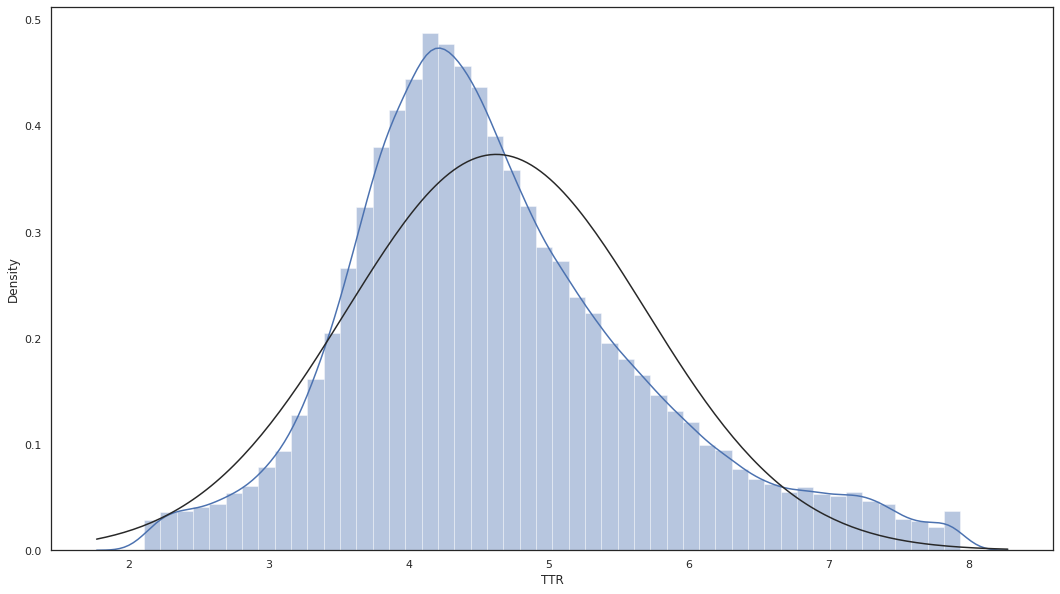

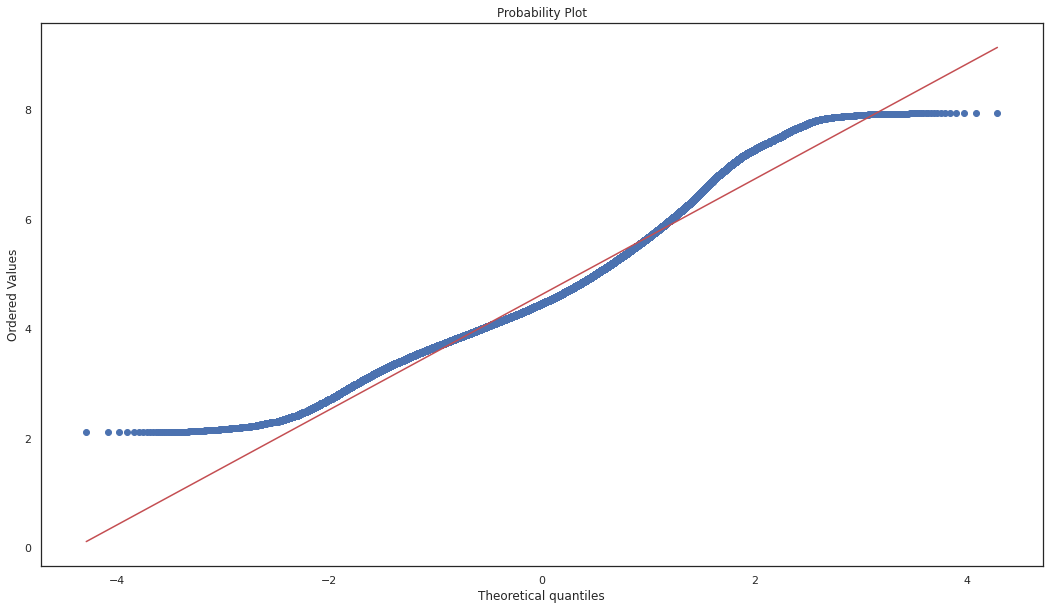

In [10]:
from scipy.stats import norm
from scipy import stats

sns.set(rc={'figure.figsize':(16,10)})
sns.set_style("white")

sns.distplot(ads['TTR'],fit=norm);
fig = plt.figure()
print('\n')
print('\n')
res = stats.probplot(ads['TTR'], plot=plt)

In [11]:
# X_v1 = ads.copy(deep=True)
# y_v1 = ads['TTR']

X = ads[feautres_list]
y = ads['TTR']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('\n')
print('\n')
print(len(X_train),len(X_test))
print(len(y_train),len(y_test))
print('\n')
print('\n')





61420 15356
61420 15356






In [13]:
X_test_v1 = pd.merge(X_test, ads[['Marker_Location', 'Dispatch_Location', 'ZONE', 'EVENT']], left_index=True, right_index=True)
X_test_v1['EVENT'].value_counts()

BLUE SKY    12229
STORM        3127
Name: EVENT, dtype: int64

In [14]:
################################################################################# USER DEFINED FIELDS ###########################################################################################
#################################################################################################################################################################################################

select_columns_from_ads = ['CALL_QTY', 'DOWNSTREAM_CUST_QTY', 'KEY_CUST_QTY', 'DAY_FLAG', 'TTR', 'POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG',
                           'POWER_OUT_CLUE_FLG', 'OPEN_DEVICE_CLUE_FLG', 'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG', 'IVR_CLUE_FLG', 'EQUIPMENT_CLUE_FLG',
                           'TRANSFORMER_CLUE_FLG', 'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG', 'WEATHER_CAUSE_FLG', 'WEATHER_COLD_CAUSE_FLG', 
                           'PUBLIC_CAUSE_FLG', 'WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG', 'WEATHER__WIND_CAUSE_FLG', 'WEATHER__HEAT_CAUSE_FLG', 
                           'CUST_REQUEST_CAUSE_FLG', 'WEATHER__FLOOD_CAUSE_FLG', 'STREET_CAUSE_FLG', 'SUBSTATION_CAUSE_FLG', 'TREE_CAUSE_FLG', 'MISCELLANEOUS_CAUSE_FLG',
                           'NO_CAUSE_FLG', 'PLANNED_CAUSE_FLG', 'NO_OUTAGE_CAUSE_FLG', 'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 
                           'TRANSFORMER_OCCURN_FLG', 'METER_OCCURN_FLG', 'SERVICE_OCCURN_FLG', 'CABLE_OCCURN_FLG', 'ST_OCCURN_FLG', 'FIRE_OCCURN_FLG', 
                           'FOUND_OPEN_OCCURN_FLG', 'PUBLIC_SAFETY_OCCURN_FLG', 'WIRE_OCCURN_FLG', 'SWITCH_OCCURN_FLG', 'REGULATOR_OCCURN_FLG', 
                           'CUTOUT_OCCURN_FLG', 'CAP_BANK_OCCURN_FLG', 'RECLOSER_OCCURN_FLG', 'OH_OCCURN_FLG', 'PRIORITY_VAL_1.0', 'PRIORITY_VAL_2.0',
                           'PRIORITY_VAL_3.0', 'PRIORITY_VAL_5.0', 'CITY_NAM', 'ZONE', 'NO_OF_POWER_OUT_CLUE_PER_DAY', 'NO_OF_OPEN_DEVICE_CLUE_PER_DAY',
                           'NO_OF_IVR_CLUE_PER_DAY', 'NO_OF_ANIMAL_CAUSE_PER_DAY', 'NO_OF_WIRE_OCCURN_PER_DAY', 'Hour_Sin', 'Hour_Cos', 'RANK_SUBSEQUENT_OUTAGES', 
                           'Outages_in_last_1hr', 'Outages_in_last_2hr', 'Outages_in_last_3hr', 'Outages_in_last_4hr', 'Outages_in_last_5hr', 'Outages_in_last_6hr',
                           'Outages_in_last_7hr', 'Outages_in_last_8hr', 'Outages_in_last_9hr', 'Outages_in_last_10hr', 'Weekday', 'Weekend_flag',
                           'Priority_Customer_Qty', 'Priority_Dist_Customer_Qty', 'Dispatch_Location', 'cldCvrAvg', 'cldCvrMax', 'cldCvrMin', 'dewPtAvg', 
                           'dewPtMax', 'dewPtMin', 'feelsLikeAvg', 'feelsLikeMax', 'feelsLikeMin', 'heatIndexAvg', 'heatIndexMax', 'heatIndexMin', 'mslPresAvg',
                           'mslPresMax', 'mslPresMin', 'precip', 'radSolarAvg', 'radSolarMax', 'radSolarTot', 'relHumAvg', 'relHumMax', 'relHumMin', 'sfcPresAvg', 
                           'sfcPresMax', 'sfcPresMin', 'snowfall', 'spcHumAvg', 'spcHumMax', 'spcHumMin', 'tempAvg', 'tempMax', 'tempMin', 'wetBulbAvg', 'wetBulbMax',
                           'wetBulbMin', 'windChillAvg', 'windChillMax', 'windChillMin', 'windDir100mAvg', 'windDir80mAvg', 'windDirAvg', 'windSpd100mAvg',
                           'windSpd100mMax', 'windSpd100mMin', 'windSpd80mAvg', 'windSpd80mMax', 'windSpd80mMin', 'windSpdAvg', 'windSpdMax', 'windSpdMin', 
                           'tempRange', 'windSpdRange', 'sfcPresRange', 'cldCvrRange', 'relHumRange', 'relHumRatio', 'sfcPresRatio', 'Marker_Location']

ads = load_ads[select_columns_from_ads]

ads = pd.get_dummies(ads, columns=['DAY_FLAG', 'POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG', 'POWER_OUT_CLUE_FLG', 
                                   'OPEN_DEVICE_CLUE_FLG', 'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG', 'IVR_CLUE_FLG', 'EQUIPMENT_CLUE_FLG',
                                   'TRANSFORMER_CLUE_FLG', 'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG', 'WEATHER_CAUSE_FLG', 
                                   'WEATHER_COLD_CAUSE_FLG', 'PUBLIC_CAUSE_FLG', 'WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG', 
                                   'WEATHER__WIND_CAUSE_FLG', 'WEATHER__HEAT_CAUSE_FLG', 'CUST_REQUEST_CAUSE_FLG', 'WEATHER__FLOOD_CAUSE_FLG', 
                                   'STREET_CAUSE_FLG', 'SUBSTATION_CAUSE_FLG', 'TREE_CAUSE_FLG', 'MISCELLANEOUS_CAUSE_FLG', 'NO_CAUSE_FLG', 
                                   'PLANNED_CAUSE_FLG', 'NO_OUTAGE_CAUSE_FLG', 'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 
                                   'TRANSFORMER_OCCURN_FLG', 'METER_OCCURN_FLG', 'SERVICE_OCCURN_FLG', 'CABLE_OCCURN_FLG', 'ST_OCCURN_FLG',
                                   'FIRE_OCCURN_FLG', 'FOUND_OPEN_OCCURN_FLG', 'PUBLIC_SAFETY_OCCURN_FLG', 'WIRE_OCCURN_FLG', 'SWITCH_OCCURN_FLG', 
                                   'REGULATOR_OCCURN_FLG', 'CUTOUT_OCCURN_FLG', 'CAP_BANK_OCCURN_FLG', 'RECLOSER_OCCURN_FLG', 'OH_OCCURN_FLG', 
                                   'PRIORITY_VAL_1.0', 'PRIORITY_VAL_2.0', 'PRIORITY_VAL_3.0', 'PRIORITY_VAL_5.0', 'CITY_NAM', 
                                   'ZONE', 'Weekday', 'Weekend_flag', 'Dispatch_Location'])

In [15]:
######################################################################## ALL USER DEFINED FUNCTION ARE LOGGED HERE #############################################################################
################################################################################################################################################################################################

# calculate rmse scores
def rmse(pred_test, y_test):
    return np.sqrt(((pred_test - y_test) ** 2).mean())

# calculate mape scores
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# get names of all categorical data present in data
def get_index_of_categorical_columns(df):
    cols = df.columns
    num_cols = df._get_numeric_data().columns
    return list(set(cols) - set(num_cols))


def do_union(lst1, lst2, lst3, lst4): 
    final_list = list(set(lst1) | set(lst2) | set(lst3) | set(lst4))
    return final_list 

In [16]:
model_col = ['MODEL_NAME' , 'TEST_MSE', 'TEST_RMSE', 'TEST_MAE', 'TEST_MAPE', 'TEST_R2']
model_result_df = pd.DataFrame(columns=model_col)
data_test_list = pd.DataFrame() 
i=0

In [17]:
y_test_pred = rf_model.predict(X_test)
y_test_pred = np.exp(y_test_pred)

y_test = np.exp(y_test)

mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = rmse(y_test,y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test,y_test_pred)
r2_test = r2_score(y_test,y_test_pred)

data_test = pd.DataFrame({'Model':'Random Forest Gridsearch', 'Test_Predicted': list(y_test_pred),'Test_Actual': list(y_test)})
data_test_list = data_test_list.append(data_test)
data_test_list.reset_index(drop=True, inplace=True)

model_result_df.loc[i] = ['Random Forest Gridsearch', mse_test, rmse_test, mae_test, mape_test, r2_test]
i = i + 1

In [18]:
model_result_df.head()

,MODEL_NAME,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE,TEST_R2
0,Random Forest Gridsearch,39629.60,199.07,92.55,62.35,0.69


In [19]:
X_test_v1.reset_index(drop=True, inplace=True)
X_test_v1

,windDir100mAvg,POWER_OUT_CLUE_FLG_True,Hour_Cos,FUSE_OCCURN_FLG_False,NO_OF_IVR_CLUE_PER_DAY,NO_OF_POWER_OUT_CLUE_PER_DAY,Outages_in_last_1hr,Priority_Customer_Qty,ANIMAL_CAUSE_FLG_False,UG_CAUSE_FLG_False,tempRange,NO_OF_WIRE_OCCURN_PER_DAY,radSolarTot,PUBLIC_SAFETY_OCCURN_FLG_True,Outages_in_last_10hr,NO_CAUSE_FLG_False,cldCvrRange,windSpd80mMax,Hour_Sin,CALL_QTY,NO_OF_OPEN_DEVICE_CLUE_PER_DAY,TREE_CAUSE_FLG_True,Outages_in_last_2hr,TREE_CAUSE_FLG_False,Priority_Dist_Customer_Qty,relHumAvg,POLE_CLUE_FLG_False,DOWNSTREAM_CUST_QTY,Outages_in_last_9hr,heatIndexMax,DAY_FLAG_True,WIRE_OCCURN_FLG_False,ANIMAL_CAUSE_FLG_True,ST_OCCURN_FLG_False,CITY_NAM_NO_CITY,PUBLIC_SAFETY_OCCURN_FLG_False,ST_OCCURN_FLG_True,POWER_OUT_CLUE_FLG_False,Marker_Location,Dispatch_Location,ZONE,EVENT
0,49.00,1,0.97,1,7,15,0,1.00,1,0,10.10,0,2046.00,0,11,1,69.00,14.10,-0.26,3,2,0,1,1,1.00,90.10,1,15.00,7,67.10,0,1,0,1,0,1,0,0,Marker4,ARL.,ZONE3,BLUE SKY
1,89.00,1,-0.87,0,10,15,1,6.00,0,1,11.10,0,552.00,0,2,1,30.00,24.00,0.50,4,3,0,1,1,6.00,82.00,1,9.00,2,53.50,1,1,1,1,0,1,0,0,Marker3,ARL.,ZONE3,BLUE SKY
2,202.00,1,-0.71,1,35,60,6,41.00,1,1,6.00,11,518.60,0,11,1,100.00,17.80,0.71,3,8,1,10,0,90.00,93.00,1,4.00,11,71.50,1,0,0,1,0,1,0,0,Marker3,34th,ZONE4,STORM
3,163.00,1,0.87,0,6,9,0,3.00,1,0,28.10,2,4882.00,0,10,1,86.00,9.20,0.50,3,3,0,0,1,3.00,68.90,1,8.00,5,88.10,0,1,0,1,0,1,0,0,Marker5,ARL.,ZONE3,BLUE SKY
4,198.00,1,-0.71,0,7,14,1,2.00,1,1,15.20,1,6727.00,0,16,1,94.00,16.90,-0.71,2,10,0,1,1,2.00,79.00,1,4.00,16,82.20,1,1,0,1,0,1,0,0,Marker12,SOUTH,ZONE2,BLUE SKY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15351,248.00,0,-0.87,1,10,24,2,2.00,1,1,25.30,1,7855.30,1,14,1,92.00,11.80,-0.50,1,4,1,2,0,1.00,58.00,1,33.00,14,99.90,1,1,0,1,0,0,0,1,Marker12,ENGLISH,ZONE3,BLUE SKY
15352,269.00,1,0.71,1,18,31,0,43.00,1,0,14.80,6,8126.80,0,46,1,79.00,15.90,0.71,4,8,0,1,1,67.00,74.00,1,4.00,45,85.50,0,1,0,1,0,1,0,0,Marker5,ARL.,ZONE3,BLUE SKY
15353,195.00,1,-0.97,0,4,12,1,1.00,1,1,14.30,2,954.90,0,10,1,61.00,25.30,0.26,2,6,0,3,1,1.00,88.10,1,7.00,10,58.30,1,1,0,1,0,1,0,0,Marker12,ENGLISH,ZONE3,BLUE SKY
15354,262.00,1,-0.26,0,6,15,0,4.00,0,1,19.80,0,4167.00,0,12,1,31.00,13.30,-0.97,8,3,0,1,1,3.00,68.10,1,9.00,12,47.90,1,1,1,1,0,1,0,0,Marker13,ENGLISH,ZONE3,BLUE SKY


In [20]:
data_test_list[['Test_Predicted', 'Test_Actual']]

,Test_Predicted,Test_Actual
0,82.46,92.93
1,59.82,71.45
2,253.79,205.17
3,89.69,90.97
4,73.74,67.83
...,...,...
15351,27.58,11.00
15352,200.06,264.20
15353,51.59,82.42
15354,58.45,29.32


In [21]:
X_test_final = pd.merge(X_test_v1[['Marker_Location', 'Dispatch_Location', 'ZONE', 'EVENT']], data_test_list[['Test_Predicted', 'Test_Actual']], left_index=True, right_index=True)
X_test_final

,Marker_Location,Dispatch_Location,ZONE,EVENT,Test_Predicted,Test_Actual
0,Marker4,ARL.,ZONE3,BLUE SKY,82.46,92.93
1,Marker3,ARL.,ZONE3,BLUE SKY,59.82,71.45
2,Marker3,34th,ZONE4,STORM,253.79,205.17
3,Marker5,ARL.,ZONE3,BLUE SKY,89.69,90.97
4,Marker12,SOUTH,ZONE2,BLUE SKY,73.74,67.83
...,...,...,...,...,...,...
15351,Marker12,ENGLISH,ZONE3,BLUE SKY,27.58,11.00
15352,Marker5,ARL.,ZONE3,BLUE SKY,200.06,264.20
15353,Marker12,ENGLISH,ZONE3,BLUE SKY,51.59,82.42
15354,Marker13,ENGLISH,ZONE3,BLUE SKY,58.45,29.32


In [22]:
X_test_final.to_csv('gs://aes-datahub-0002-curated/Outage_Restoration/Historical_Data/Master_Dataset/EVENT_test_data_10142020.csv',index = False)

In [ ]:
data_test_list.to_csv('gs://aes-datahub-0002-curated/Outage_Restoration/Historical_Data/Master_Dataset/test_data_hyperparametertuned_RF_model.csv',index = False)